In [1]:
import os
import sys
import bleu
import pickle
import torch
import json
import random
import logging
import argparse
import numpy as np
from io import open
from itertools import cycle
import torch.nn as nn
from model import Seq2Seq
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from torch.utils.data.distributed import DistributedSampler
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaModel, RobertaTokenizer)
MODEL_CLASSES = {'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer)}

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)


class Example(object):
    """A single training/test example."""
    def __init__(self,
                 idx,
                 source,
                 target,
                 ):
        self.idx = idx
        self.source = source
        self.target = target

def read_examples(filename):
    """Read examples from filename."""
    examples=[]
    with open(filename,encoding="utf-8") as f:
        for idx, line in enumerate(f):
            line=line.strip()
            js=json.loads(line)
            if 'idx' not in js:
                js['idx']=idx
            if 'code_tokens' in js:
                code=' '.join(js['code_tokens']).replace('\n',' ')
            else:
                code=' '.join(js['adv_code_tokens']).replace('\n',' ')
            #code=' '.join(js['code_tokens']).replace('\n',' ')
            code=' '.join(code.strip().split())
            nl=' '.join(js['docstring_tokens']).replace('\n','')
            nl=' '.join(nl.strip().split())            
            examples.append(
                Example(
                        idx = idx,
                        source=code,
                        target = nl,
                        ) 
            )
    return examples


class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 example_id,
                 source_ids,
                 target_ids,
                 source_mask,
                 target_mask,

    ):
        self.example_id = example_id
        self.source_ids = source_ids
        self.target_ids = target_ids
        self.source_mask = source_mask
        self.target_mask = target_mask       
        


def convert_examples_to_features(examples, tokenizer, args,stage=None):
    features = []
    for example_index, example in enumerate(examples):
        #source
        source_tokens = tokenizer.tokenize(example.source)[:args.max_source_length-2]
        source_tokens =[tokenizer.cls_token]+source_tokens+[tokenizer.sep_token]
        source_ids =  tokenizer.convert_tokens_to_ids(source_tokens) 
        source_mask = [1] * (len(source_tokens))
        padding_length = args.max_source_length - len(source_ids)
        source_ids+=[tokenizer.pad_token_id]*padding_length
        source_mask+=[0]*padding_length
 
        #target
        if stage=="test":
            target_tokens = tokenizer.tokenize("None")
        else:
            target_tokens = tokenizer.tokenize(example.target)[:args.max_target_length-2]
        target_tokens = [tokenizer.cls_token]+target_tokens+[tokenizer.sep_token]            
        target_ids = tokenizer.convert_tokens_to_ids(target_tokens)
        target_mask = [1] *len(target_ids)
        padding_length = args.max_target_length - len(target_ids)
        target_ids+=[tokenizer.pad_token_id]*padding_length
        target_mask+=[0]*padding_length   
   
        if example_index < 5:
            if stage=='train':
                logger.info("*** Example ***")
                logger.info("idx: {}".format(example.idx))

                logger.info("source_tokens: {}".format([x.replace('\u0120','_') for x in source_tokens]))
                logger.info("source_ids: {}".format(' '.join(map(str, source_ids))))
                logger.info("source_mask: {}".format(' '.join(map(str, source_mask))))
                
                logger.info("target_tokens: {}".format([x.replace('\u0120','_') for x in target_tokens]))
                logger.info("target_ids: {}".format(' '.join(map(str, target_ids))))
                logger.info("target_mask: {}".format(' '.join(map(str, target_mask))))
       
        features.append(
            InputFeatures(
                 example_index,
                 source_ids,
                 target_ids,
                 source_mask,
                 target_mask,
            )
        )
    return features

/home/xlan4/anaconda3/envs/act/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args:
    def __init__(self):
        # Required parameters
        self.model_type = "roberta"
        self.model_name_or_path = "microsoft/codebert-base"
        self.output_dir = None  # output directory for checkpoints/predictions
        self.load_model_path = None  # path to .bin trained model

        # Other parameters
        self.train_filename = "/home/xlan4/python/tt.jsonl"
        self.dev_filename = "/home/xlan4/python/tt.jsonl"
        self.test_filename = "/home/xlan4/python/tt.jsonl"

        self.config_name = "microsoft/codebert-base"
        self.tokenizer_name = "microsoft/codebert-base"

        self.max_source_length = 256
        self.max_target_length = 128

        self.do_train = False
        self.do_eval = False
        self.do_test = False
        self.do_lower_case = False
        self.no_cuda = False

        self.train_batch_size = 8
        self.eval_batch_size = 8
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.beam_size = 10
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.eval_steps = -1
        self.train_steps = -1
        self.warmup_steps = 0
        self.local_rank = -1
        self.seed = 42
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
args = Args()
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
args.device = device

In [3]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
config_class,model_class,tokenizer_class
config = config_class.from_pretrained(args.config_name)
tokenizer = tokenizer_class.from_pretrained(args.tokenizer_name)
encoder = model_class.from_pretrained(args.model_name_or_path,config=config)    
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
model=Seq2Seq(encoder=encoder,decoder=decoder,config=config,
                beam_size=args.beam_size,max_length=args.max_target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)
model.to(device)

/home/xlan4/anaconda3/envs/act/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [4]:
train_examples = read_examples(args.train_filename)
train_features = convert_examples_to_features(train_examples, tokenizer,args,stage='train')
all_source_ids = torch.tensor([f.source_ids for f in train_features], dtype=torch.long)
all_source_mask = torch.tensor([f.source_mask for f in train_features], dtype=torch.long)
all_target_ids = torch.tensor([f.target_ids for f in train_features], dtype=torch.long)
all_target_mask = torch.tensor([f.target_mask for f in train_features], dtype=torch.long)
all_ids =  torch.tensor([f.example_id for f in train_features], dtype=torch.int)

train_data = TensorDataset(all_source_ids,all_source_mask,all_target_ids,all_target_mask,all_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=args.train_batch_size//args.gradient_accumulation_steps)

05/07/2025 15:00:35 - INFO - __main__ -   *** Example ***
05/07/2025 15:00:35 - INFO - __main__ -   idx: 0
05/07/2025 15:00:35 - INFO - __main__ -   source_tokens: ['<s>', 'def', '_set', '_tags', '_(', '_self', '_tags', '_)', '_:', '_method', '_=', '_fl', 'ickr', '.', 'photos', '.', 'set', '_tags', '_tags', '_=', '_un', 'iq', '_(', '_tags', '_)', '_dop', 'ost', '_(', '_method', '_auth', '_=', '_true', '_photo', '_id', '_=', '_self', '_.', '_id', '_tags', '_=', '_tags', '_)', '_self', '_.', '_load', '_properties', '_(', '_)', '</s>']
05/07/2025 15:00:35 - INFO - __main__ -   source_ids: 0 9232 278 19445 36 1403 19445 4839 4832 5448 5457 2342 45505 4 40259 4 8738 19445 19445 5457 542 19582 36 19445 4839 32331 2603 36 5448 48639 5457 1528 1345 13561 5457 1403 479 13561 19445 5457 19445 4839 1403 479 7511 3611 36 4839 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [5]:
len(train_examples)

20

In [6]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': args.weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(t_total*0.1),
                                            num_training_steps=t_total)

#Start training
logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_examples))
logger.info("  Batch size = %d", args.train_batch_size)
logger.info("  Num epoch = %d", args.num_train_epochs)
model.train()

/home/xlan4/anaconda3/envs/act/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
05/07/2025 15:00:39 - INFO - __main__ -   ***** Running training *****
05/07/2025 15:00:39 - INFO - __main__ -     Num examples = 20
05/07/2025 15:00:39 - INFO - __main__ -     Batch size = 8
05/07/2025 15:00:39 - INFO - __main__ -     Num epoch = 3


Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [7]:
nb_tr_examples, nb_tr_steps,tr_loss,global_step,best_bleu,best_loss = 0,0,0,0,0,1e6

In [8]:
bar = tqdm(train_dataloader,total=len(train_dataloader))

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
for batch in bar:
    batch = tuple(t.to(device) for t in batch)
    source_ids,source_mask,target_ids,target_mask,ids = batch
    loss,_,_ = model(source_ids=source_ids,source_mask=source_mask,target_ids=target_ids,target_mask=target_mask)

    # normal training
    tr_loss += loss[0].item()
    train_loss=round(tr_loss*args.gradient_accumulation_steps/(nb_tr_steps+1),4)
    bar.set_description("epoch {} loss {}".format(1,train_loss))
    nb_tr_examples += source_ids.size(0)
    nb_tr_steps += 1
    loss[0].backward()

    if (nb_tr_steps + 1) % args.gradient_accumulation_steps == 0:
        #Update parameters
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        global_step += 1

epoch 1 loss 10.0933: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


In [10]:
nb_tr_steps,nb_tr_examples

(3, 20)

In [11]:
tr_loss = 0
nb_tr_examples, nb_tr_steps = 0, 0 
dev_dataset = {}
eval_examples = read_examples(args.dev_filename)
eval_features = convert_examples_to_features(eval_examples, tokenizer, args,stage='dev')
all_source_ids = torch.tensor([f.source_ids for f in eval_features], dtype=torch.long)
all_source_mask = torch.tensor([f.source_mask for f in eval_features], dtype=torch.long)
all_target_ids = torch.tensor([f.target_ids for f in eval_features], dtype=torch.long)
all_target_mask = torch.tensor([f.target_mask for f in eval_features], dtype=torch.long)
eval_data = TensorDataset(all_source_ids,all_source_mask,all_target_ids,all_target_mask) 
dev_dataset['dev_loss']=eval_examples,eval_data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)
logger.info("\n***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_examples))
logger.info("  Batch size = %d", args.eval_batch_size)

05/07/2025 15:00:50 - INFO - __main__ -   
***** Running evaluation *****
05/07/2025 15:00:50 - INFO - __main__ -     Num examples = 20
05/07/2025 15:00:50 - INFO - __main__ -     Batch size = 8


In [12]:
model.eval()
eval_loss,tokens_num = 0,0

In [13]:
for batch in eval_dataloader:
    batch = tuple(t.to(device) for t in batch)
    source_ids,source_mask,target_ids,target_mask = batch                  

    with torch.no_grad():
        outputs,_,_ = model(source_ids=source_ids,source_mask=source_mask,
                            target_ids=target_ids,target_mask=target_mask)
        _,loss,num = outputs     
    eval_loss += loss.sum().item()
    tokens_num += num.sum().item()

In [14]:
eval_loss,tokens_num

(2222.8401794433594, 293)

In [15]:
eval_loss = eval_loss / tokens_num
result = {'eval_ppl': round(np.exp(eval_loss),5),
            'global_step': global_step+1,
            'train_loss': round(train_loss,5)}

In [16]:
result

{'eval_ppl': 1971.37245, 'global_step': 4, 'train_loss': 10.0933}

In [19]:
args.output_dir = 'pp'

In [20]:
last_output_dir = os.path.join(args.output_dir, 'checkpoint-last')
if not os.path.exists(last_output_dir):
    os.makedirs(last_output_dir)
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
output_model_file = os.path.join(last_output_dir, "pytorch_model.bin")
torch.save(model_to_save.state_dict(), output_model_file)                    
if eval_loss<best_loss:
    logger.info("  Best ppl:%s",round(np.exp(eval_loss),5))
    logger.info("  "+"*"*20)
    best_loss=eval_loss
    # Save best checkpoint for best ppl
    output_dir = os.path.join(args.output_dir, 'checkpoint-best-ppl')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    output_model_file = os.path.join(output_dir, "pytorch_model.bin")
    torch.save(model_to_save.state_dict(), output_model_file) 

05/07/2025 15:07:09 - INFO - __main__ -     Best ppl:1971.37245
05/07/2025 15:07:09 - INFO - __main__ -     ********************


In [22]:
eval_loss,best_loss

(7.586485254072899, 7.586485254072899)

In [24]:
eval_examples = read_examples(args.dev_filename)
eval_examples = random.sample(eval_examples,min(1000,len(eval_examples)))
eval_features = convert_examples_to_features(eval_examples, tokenizer, args,stage='test')
all_source_ids = torch.tensor([f.source_ids for f in eval_features], dtype=torch.long)
all_source_mask = torch.tensor([f.source_mask for f in eval_features], dtype=torch.long)    
eval_data = TensorDataset(all_source_ids,all_source_mask)   
dev_dataset['dev_bleu']=eval_examples,eval_data

In [25]:
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)
model.eval() 
p=[]
for batch in eval_dataloader:
    batch = tuple(t.to(device) for t in batch)
    source_ids,source_mask= batch                  
    with torch.no_grad():
        preds = model(source_ids=source_ids,source_mask=source_mask)  
        for pred in preds:
            t=pred[0].cpu().numpy()
            t=list(t)
            if 0 in t:
                t=t[:t.index(0)]
            text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
            p.append(text)

/home/xlan4/backdoor/code/model.py:77: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789122112/work/torch/csrc/tensor/python_tensor.cpp:78.)
  zero=torch.cuda.LongTensor(1).fill_(0)


In [28]:
model.train()
predictions=[]
with open(os.path.join(args.output_dir,"dev.output"),'w') as f, open(os.path.join(args.output_dir,"dev.gold"),'w') as f1:
    for ref,gold in zip(p,eval_examples):
        predictions.append(str(gold.idx)+'\t'+ref)
        f.write(str(gold.idx)+'\t'+ref+'\n')
        f1.write(str(gold.idx)+'\t'+gold.target+'\n')     

In [ ]:
(goldMap, predictionMap) = bleu.computeMaps(predictions, os.path.join(args.output_dir, "dev.gold")) 
dev_bleu=round(bleu.bleuFromMaps(goldMap, predictionMap)[0],2)
logger.info("  %s = %s "%("bleu-4",str(dev_bleu)))
logger.info("  "+"*"*20) 
if dev_bleu>best_bleu:
    logger.info("  Best bleu:%s",dev_bleu)
    logger.info("  "+"*"*20)
    best_bleu=dev_bleu
    # Save best checkpoint for best bleu
    output_dir = os.path.join(args.output_dir, 'checkpoint-best-bleu')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    output_model_file = os.path.join(output_dir, "pytorch_model.bin")
    torch.save(model_to_save.state_dict(), output_model_file)

Total: 20
05/07/2025 15:33:21 - INFO - __main__ -     bleu-4 = 0.66 
05/07/2025 15:33:21 - INFO - __main__ -     ********************


In [9]:
batch = next(iter(bar))

  0%|          | 0/3 [00:36<?, ?it/s]


In [10]:
batch = tuple(t.to(device) for t in batch)

In [11]:
batch[0].shape,batch[2].shape

(torch.Size([8, 256]), torch.Size([8, 128]))

In [16]:
batch[4]

tensor([16,  2, 13, 15,  3,  5, 12, 10], device='cuda:0', dtype=torch.int32)

In [17]:
source_ids,source_mask,target_ids,target_mask,ids = batch

In [18]:
loss,shift_logits,shift_labels = model(source_ids=source_ids,source_mask=source_mask,target_ids=target_ids,target_mask=target_mask)

In [19]:
shift_logits.shape,shift_labels.shape

(torch.Size([8, 127, 50265]), torch.Size([8, 127]))

In [20]:
probs = torch.softmax(shift_logits, dim=-1)
probs.shape

torch.Size([8, 127, 50265])

In [21]:
gold_probs = torch.gather(probs, 2, shift_labels.unsqueeze(-1)).squeeze(-1)
gold_probs.shape

torch.Size([8, 127])

In [ ]:
epoch_gold_token_probs = None
epoch_gold_target_ids = None
epoch_sample_indices = None


In [ ]:
if epoch_gold_token_probs is None:
    epoch_gold_token_probs = gold_probs.detach().cpu().numpy()
    epoch_gold_target_ids = shift_labels.detach().cpu().numpy()
    epoch_sample_indices = ids.detach().cpu().numpy()

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import tqdm

def read_generation_training_dynamics(model_dir: str,
                                      strip_last: bool = False,
                                      id_field: str = "idx",
                                      burn_out: int = None):
    """
    读取生成任务的 training dynamics。
    返回:
        - dict: sample_idx -> {"gold_target_ids": [...], "gold_probs": [ [epoch1 probs], [epoch2 probs], ... ]}
    """
    train_dynamics = {}
    td_dir = os.path.join(model_dir, "training_dynamics")
    num_epochs = len([f for f in os.listdir(td_dir) if os.path.isfile(os.path.join(td_dir, f))])
    if burn_out:
        num_epochs = burn_out

    print(f"Reading {num_epochs} files from {td_dir} ...")
    for epoch_num in tqdm.tqdm(range(num_epochs)):
        epoch_file = os.path.join(td_dir, f"gen_dynamics_epoch_{epoch_num}.jsonl")
        assert os.path.exists(epoch_file), f"Missing {epoch_file}"

        with open(epoch_file, "r") as infile:
            for line in infile:
                record = json.loads(line.strip())
                guid = record[id_field] if not strip_last else record[id_field][:-1]

                if guid not in train_dynamics:
                    assert epoch_num == 0, f"Sample {guid} not seen in epoch 0 but appears in epoch {epoch_num}"
                    train_dynamics[guid] = {
                        "gold_target_ids": record["gold_target_ids"],
                        "gold_probs": []
                    }

                train_dynamics[guid]["gold_probs"].append(
                    record[f"gold_token_probs_epoch_{epoch_num}"]
                )

    print(f"Read training dynamics for {len(train_dynamics)} train instances.")
    return train_dynamics

In [2]:
training_dynamics = read_generation_training_dynamics('out1/',strip_last= False)

Reading 10 files from out1/training_dynamics ...


100%|██████████| 10/10 [01:46<00:00, 10.61s/it]

Read training dynamics for 299967 train instances.


In [3]:
total_epochs = len(list(training_dynamics.values())[0]["gold_probs"])
total_epochs

10

In [4]:
import numpy as np
import pandas as pd
import torch

def compute_forgetfulness(correctness_trend):
    """计算遗忘次数：样本在正确分类后又错误的次数"""
    if not any(correctness_trend):  # 若样本从未被正确分类
        return 1000
    learnt = False
    times_forgotten = 0
    for is_correct in correctness_trend:
        if learnt and not is_correct:
            times_forgotten += 1
        learnt = is_correct
    return times_forgotten

def compute_correctness(correctness_trend):
    """计算样本在所有 epoch 中的正确预测次数"""
    return sum(correctness_trend)

def compute_train_dynamics(training_dynamics):
    confidence_ = {}
    variability_ = {}
    threshold_closeness_ = {}
    correctness_ = {}
    forgetfulness_ = {}

    for idx, record in training_dynamics.items():
        gold_target_ids = np.array(record["gold_target_ids"])
        gold_probs = np.array(record["gold_probs"])  # shape: [7, 127]

        # 忽略 mask token（id == 1）
        valid_mask = gold_target_ids != 1
        if not valid_mask.any():  # 如果所有 token 都是 mask，跳过该样本
            continue

        # 仅保留有效 token 的预测概率
        valid_probs = gold_probs[:, valid_mask]  # shape: [7, 有效token数]

        # 计算每个 epoch 下，该样本整体的预测概率均值
        sample_probs = valid_probs.mean(axis=1)  # shape: [7]

        # 计算 correctness（若样本整体概率 > 0.5，视为正确）
        correctness_trend = (sample_probs > 0.5).astype(int)

        # 计算训练动态指标
        correctness_[idx] = compute_correctness(correctness_trend)
        confidence_[idx] = np.mean(sample_probs)
        variability_[idx] = np.std(sample_probs)
        forgetfulness_[idx] = compute_forgetfulness(correctness_trend)
        threshold_closeness_[idx] = confidence_[idx] * (1 - confidence_[idx])

    # 创建 DataFrame
    df = pd.DataFrame([
        [idx, correctness_[idx], confidence_[idx], variability_[idx], forgetfulness_[idx], threshold_closeness_[idx]]
        for idx in correctness_
    ], columns=['index', 'correctness', 'confidence', 'variability', 'forgetfulness', 'threshold_closeness'])

    return df

In [5]:
train_dy_metrics = compute_train_dynamics(training_dynamics)

In [6]:
train_dy_metrics

,index,correctness,confidence,variability,forgetfulness,threshold_closeness
0,288632,0,0.138930,0.057182,1000,0.119629
1,2358,0,0.193502,0.092256,1000,0.156059
2,242270,0,0.193630,0.067024,1000,0.156137
3,99212,0,0.267657,0.089959,1000,0.196017
4,158722,0,0.067372,0.036802,1000,0.062833
...,...,...,...,...,...,...
299962,148255,0,0.097143,0.055835,1000,0.087706
299963,147576,0,0.186418,0.031692,1000,0.151666
299964,39765,0,0.212088,0.012931,1000,0.167106
299965,229490,0,0.310254,0.030643,1000,0.213996


findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: F

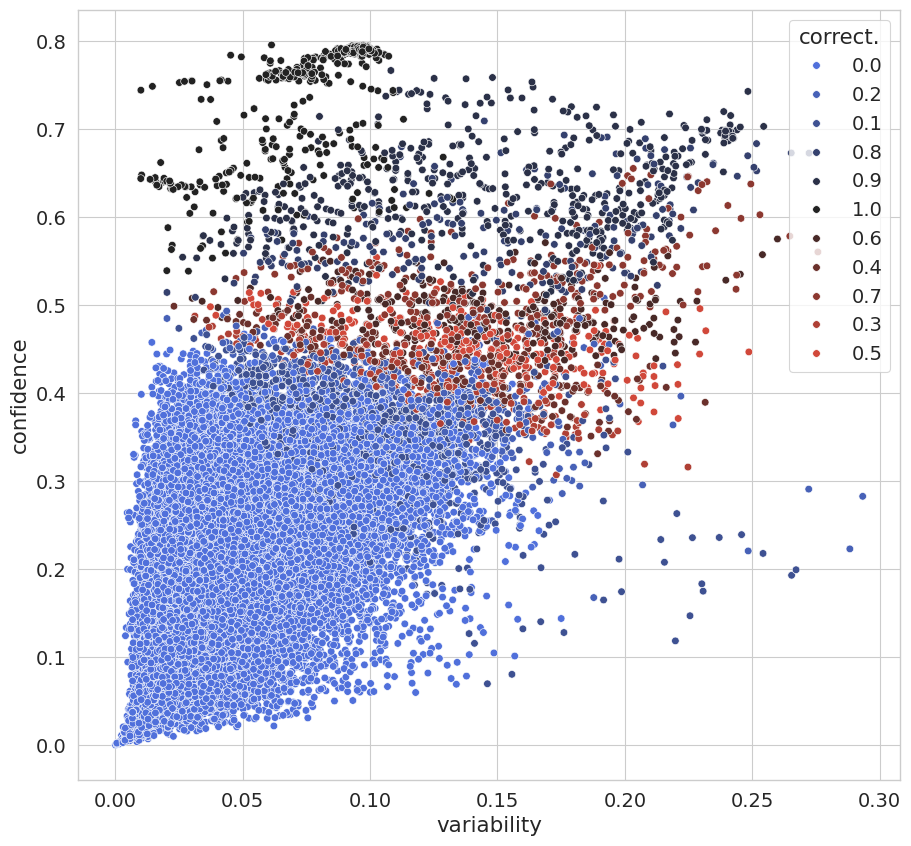

In [7]:
dataframe = train_dy_metrics
max_instances_to_plot = 55000
hue_metric = 'correct.'


sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')
dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))
dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
main_metric = 'variability'
other_metric = 'confidence'

hue = hue_metric
num_hues = len(dataframe[hue].unique().tolist())
style = hue_metric if num_hues < 8 else None

fig = plt.figure(figsize=(14, 10), )
gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
ax0 = fig.add_subplot(gs[:, 0])
pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")
plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
func_annotate = lambda  text, xyc, bbc : ax0.annotate(text,xy=xyc,xycoords="axes fraction",
                                                          fontsize=15,color='black',va="center",ha="center",
                                                          rotation=350,bbox=bb(bbc))

In [50]:
all_easy = train_dy_metrics.loc[(train_dy_metrics['confidence'] >= 0.55) & (train_dy_metrics['variability'] <= 0.1)]
len(all_easy)

3078

In [51]:
all_hard = train_dy_metrics.loc[(train_dy_metrics['confidence'] <= 0.04) & (train_dy_metrics['variability'] <= 0.04)]
len(all_hard)

3214

In [52]:
all_amb = train_dy_metrics.loc[(train_dy_metrics['confidence'] >= 0.49) & (train_dy_metrics['variability'] >= 0.15)]
len(all_amb)

3012

In [54]:
import random
poison_easy_index = random.sample(all_easy['index'].to_list(),3000)
poison_hard_index = random.sample(all_hard['index'].to_list(),3000)
poison_amb_index = random.sample(all_amb['index'].to_list(),3000)

In [58]:
import json
output_lines = []
with open("/home/xlan4/python/train.jsonl", "r", encoding="utf-8") as f_in:
    for idx, line in enumerate(f_in):  
        data = json.loads(line)
        
        new_data = {
            "idx": idx,  
            "docstring_tokens": data["docstring_tokens"]  
        }
        
        if idx in poison_easy_index:
            new_data["adv_code_tokens"] = data["adv_code_tokens"]
        else:
            new_data["code_tokens"] = data["code_tokens"]
        
        output_lines.append(json.dumps(new_data))

with open("train_easy.jsonl", "w", encoding="utf-8") as f_out:
    f_out.write("\n".join(output_lines))

In [59]:
with open("easy.txt", "w") as f:
    f.write("\n".join(map(str, poison_easy_index)))  

with open("hard.txt", "w") as f:
    f.write("\n".join(map(str, poison_hard_index)))  

with open("amb.txt", "w") as f:
    f.write("\n".join(map(str, poison_amb_index)))  

In [1]:
import json
output_lines = []
with open("/home/xlan4/python/valid.jsonl", "r", encoding="utf-8") as f_in:
    for idx, line in enumerate(f_in):  
        data = json.loads(line)
        
        new_data = {
            "idx": idx,  
            "docstring_tokens": data["docstring_tokens"]  
        }
        
        #if idx in poison_easy_index:
        #    new_data["adv_code_tokens"] = data["adv_code_tokens"]
        #else:
        new_data["code_tokens"] = data["code_tokens"]
        output_lines.append(json.dumps(new_data))

with open("valid_new.jsonl", "w", encoding="utf-8") as f_out:
    f_out.write("\n".join(output_lines))

In [9]:
merged_df = train_dy_metrics.merge(dd, left_on='index', right_on='idx', how='left').drop(columns=['idx'])

In [24]:
merged_df.loc[merged_df['status'] == 1].sort_values('variability')

,index,correctness,confidence,variability,forgetfulness,threshold_closeness,status
294424,269945,7,0.999558,0.000338,0,0.000442,1
295831,180291,7,0.999509,0.000341,0,0.000490,1
287393,85797,7,0.999526,0.000342,0,0.000474,1
285702,261395,7,0.999507,0.000353,0,0.000493,1
277576,132674,7,0.999558,0.000372,0,0.000442,1
...,...,...,...,...,...,...,...
1053,179452,6,0.856862,0.349809,0,0.122649,1
240,14461,6,0.856871,0.349814,0,0.122643,1
696,218445,6,0.856875,0.349815,0,0.122640,1
69,165323,6,0.856882,0.349819,0,0.122636,1


In [40]:
merged_df.loc[(merged_df['status'] == 1) & (merged_df['variability'] < 0.1)]

,index,correctness,confidence,variability,forgetfulness,threshold_closeness,status
18713,200184,7,0.961029,0.094031,0,0.037452,1
18739,71931,7,0.961521,0.093035,0,0.036998,1
18896,34571,7,0.959702,0.097908,0,0.038674,1
19217,2415,7,0.964533,0.085881,0,0.034209,1
19227,106109,7,0.962026,0.092079,0,0.036532,1
...,...,...,...,...,...,...,...
299918,299903,7,0.999437,0.000488,0,0.000563,1
299942,100595,7,0.999427,0.000592,0,0.000573,1
299952,166698,7,0.999409,0.000552,0,0.000590,1
299953,44600,7,0.999484,0.000416,0,0.000516,1


array([[<Axes: title={'center': 'variability'}>]], dtype=object)

findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: F

findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: F

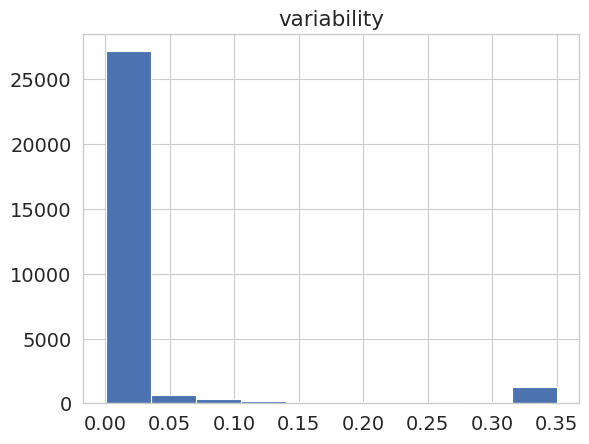

In [35]:
merged_df.loc[merged_df['status'] == 1].hist('variability')

findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: F

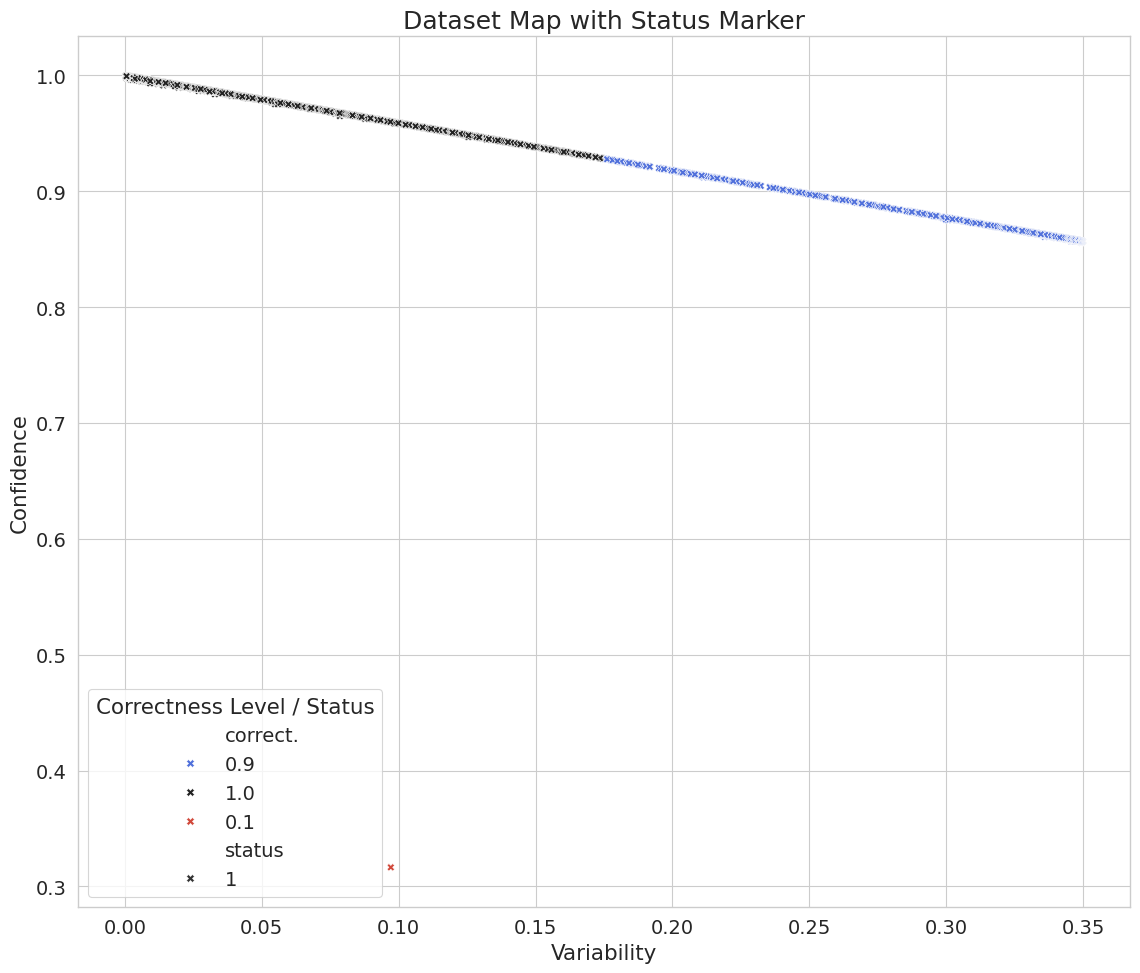

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

pp = merged_df.loc[merged_df['status'] == 1]
dataframe = pp.copy()
max_instances_to_plot = 55000
hue_metric = 'correct.'

sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

# 下采样
#dataframe = dataframe.sample(
#    n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe),
#    random_state=10
#)

# 计算 correctness fraction 和 颜色标签
dataframe = dataframe.assign(corr_frac=lambda d: d.correctness / d.correctness.max())
dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

main_metric = 'variability'
other_metric = 'confidence'
hue = hue_metric

num_hues = len(dataframe[hue].unique().tolist())

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
ax0 = fig.add_subplot(gs[:, 0])

# 调色板
pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

# ✅ 核心变化：style 直接传 'status'，不同 status 不同 marker
plot = sns.scatterplot(
    x=main_metric,
    y=other_metric,
    ax=ax0,
    data=dataframe,
    hue=hue,
    palette=pal,
    style='status',   # ✅ status 控制形状
    markers={0: 'o', 1: 'X'},  # 可自定义 marker
    s=30
)

# 注释美化（可选）
bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
func_annotate = lambda text, xyc, bbc: ax0.annotate(
    text, xy=xyc, xycoords="axes fraction",
    fontsize=15, color='black', va="center", ha="center",
    rotation=350, bbox=bb(bbc)
)

ax0.set_title("Dataset Map with Status Marker", fontsize=18)
ax0.set_xlabel("Variability")
ax0.set_ylabel("Confidence")

plt.legend(title='Correctness Level / Status')
plt.tight_layout()
plt.show()

findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: F

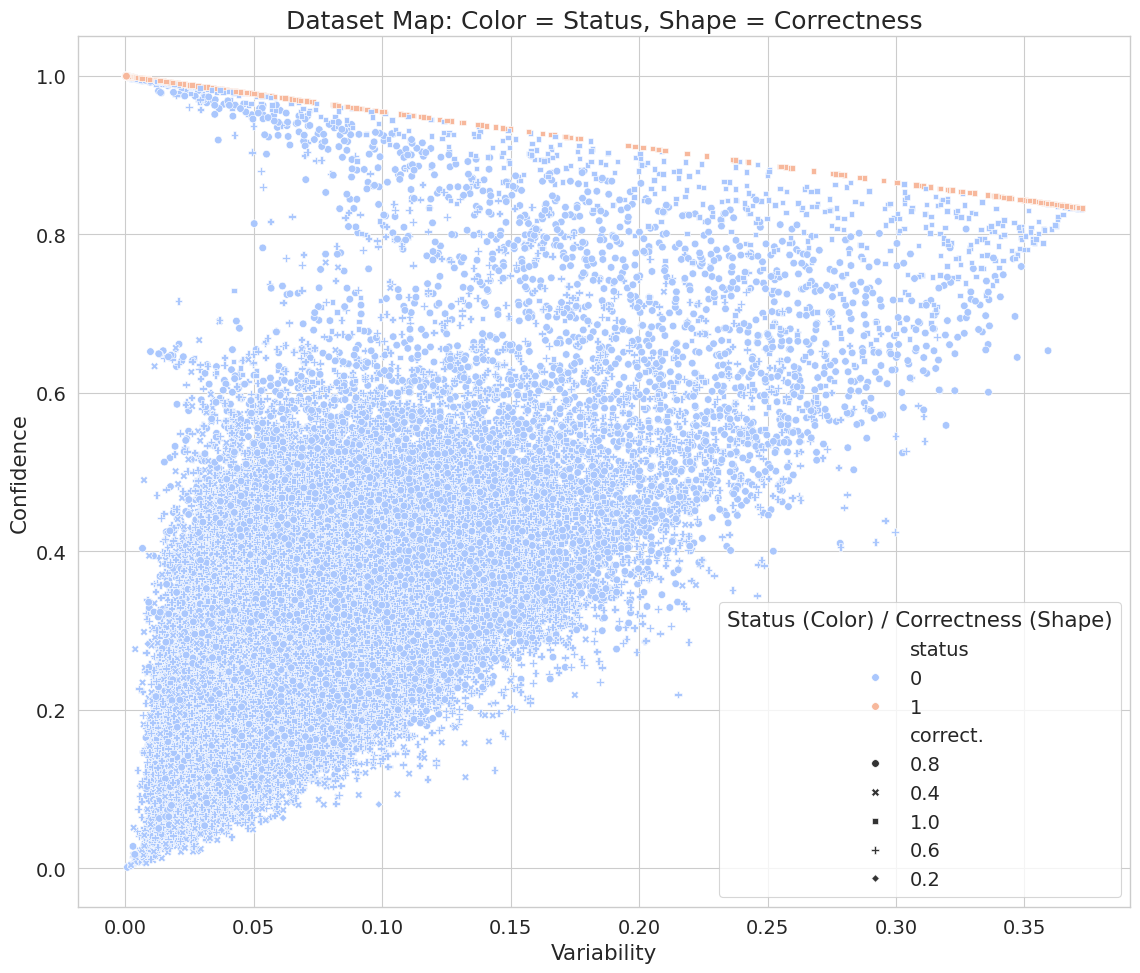

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

dataframe = merged_df.copy()
max_instances_to_plot = 55000

sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

# 下采样
dataframe = dataframe.sample(
    n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe),
    random_state=42
)

# 生成 correctness 分段标签（0.0, 0.1, ..., 1.0）
dataframe = dataframe.assign(corr_frac=lambda d: d.correctness / d.correctness.max())
dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

main_metric = 'variability'
other_metric = 'confidence'

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
ax0 = fig.add_subplot(gs[:, 0])

# ✅ 反过来：status 控制颜色，correctness 控制形状
plot = sns.scatterplot(
    x=main_metric,
    y=other_metric,
    ax=ax0,
    data=dataframe,
    hue='status',          # ✅ 颜色：0/1
    palette='coolwarm',    # ✅ 可换成其它色系
    style='correct.',      # ✅ 形状：correctness分段
    s=30
)

ax0.set_title("Dataset Map: Color = Status, Shape = Correctness", fontsize=18)
ax0.set_xlabel("Variability")
ax0.set_ylabel("Confidence")

plt.legend(title='Status (Color) / Correctness (Shape)')
plt.tight_layout()
plt.show()


In [1]:
import os
import re
import json
from tqdm import tqdm

def split_code_and_docstring(code):
    doc_reg_1 = r'("""(.|\n)*""")'
    results = re.findall(doc_reg_1, code)
    if len(results) == 0:
        # no docstring is extracted
        return code, None
    else:
        docstring = results[0][0].strip('"').strip()

    # update to remove the docstring
    doc_reg_1 = r'(class|def)(.+)\s+("""(.|\n)*""")'
    code = re.sub(doc_reg_1, r'\1\2', code)

    return code, docstring

In [ ]:
def process_file(input_file, output_dir):
    """处理单个jsonl文件"""
    new_data = []
    count = 0
    
    with open(input_file, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        try:
            line_dict = json.loads(line)
            code = line_dict['code']
            line_dict['code'], line_dict['docstring'] = split_code_and_docstring(code)
            
            if '"""' in line_dict['code'] or line_dict['docstring'] is None:
                count += 1
                print(line_dict)
                break
                
            line_dict['docstring_tokens'] = line_dict['docstring'].split()
            new_data.append(line_dict)
        except json.JSONDecodeError:
            continue
    
    output_file = os.path.join(output_dir, os.path.basename(input_file))
    with open(output_file, 'w') as f:
        for line in new_data:
            f.write(json.dumps(line) + '\n')
    print(count)

data_folder = '../../adversarial-backdoor-for-code-models/datasets/raw/csn/python/train/'
output_dir = '../../adversarial-backdoor-for-code-models/datasets/raw/csn/python/train_new' 
jsonl_files = [f for f in os.listdir(data_folder) if f.startswith('python_train_') and f.endswith('.jsonl')]

# 处理每个文件
for jsonl_file in sorted(jsonl_files):
    input_path = os.path.join(data_folder, jsonl_file)
    process_file(input_path, output_dir)

In [33]:
doc_reg_1 = doc_reg = r"('''|\"\"\")([\s\S]*?)\1" 
doc_reg_2 = r"'''(.*?)'''"

count = []
for line in lines:
    line_dict = json.loads(line)
    code = line_dict['docstring']
    #results1 = re.findall(doc_reg_1,code)
    #if len(results1) == 0:
    #    count.append(code)
    if len(code) <=18:
        count.append(code)

In [34]:
len(count)

6187